# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 9: *MaximallyStableRegions*
Compute maximally stable regions in an image 
***  

### Setup modules

In [7]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, plotImageL, createImageF, plotImageF
from PrintUtilities import printProgress

# Iteration
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    incThreshold = How much the region can increase
    timeThreshold = For how long the region must not grow to be stable
    startL = Start grey level 
    endL = End gray level 
    incL = Gray level increment
    minRegionSize = size of the smallest region

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter9/Input/")
imageName = "castle1.png"
incThreshold = 20
timeThreshold = 30
startL = 10
endL = 140
incL = 2
minRegionSize = 50
maxRegionSize = 1000

### Definition to find the most common element in a list

In [3]:
def mostCommon(lst):
    return max(set(lst), key=lst.count)

### Show input image

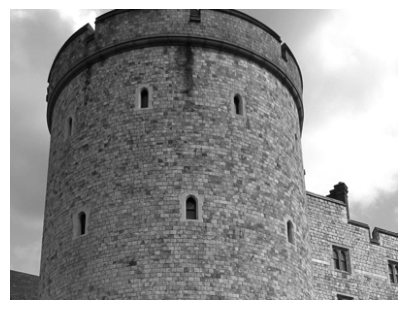

In [4]:
inputImage, width, height = imageReadL(pathToDir+imageName)
plotImageL(inputImage)

### Find regions

In [5]:
# The number of times the region has grown, its size 
timeRegions = { } 
sizeRegions = { }
incSizeRegions = { }

# Regions
regionsImage = createImageF(width, height)

# Stable regions
resultImage = createImageF(width, height)

# Use a threshold to flood regions
nextRegionID = 1
for threshold in range(startL, endL, incL):
    printProgress(threshold - startL,  endL - startL)
    
    # Init the change in size
    for regionID in incSizeRegions:
        incSizeRegions[regionID] = 0
      
    # Repeatedly flood the image to grow regions  
    flooded = True   
    while flooded:
        flooded = False
        growRegion = [ ]
        # For each non-region pixels
        for x,y in itertools.product(range(0, width), range(0, height)):      
            if inputImage[y,x] <= threshold and regionsImage[y,x] == 0:
                
                #  List of neighbours
                n = [ ]
                for wx,wy in itertools.product(range(x-1, x+2), range(y-1, y+2)):
                    if wy>=0 and wy<height and wx>=0 and wx<width:
                        neighbourID = regionsImage[wy, wx]
                        if neighbourID != 0: 
                            n.append(regionsImage[wy, wx])
                
                # Grow the most common
                if(len(n) != 0):
                    mc = mostCommon(n) 
                    growRegion.append((y,x,mc))
                    flooded  = True
        
        for pixel in growRegion:   
            y, x, idRegion = pixel[0] , pixel[1] , pixel[2]               
            regionsImage[y, x] = idRegion
            incSizeRegions[idRegion] += 1
        
    # Repeatedly merge regions
    merged = True
    while merged:
        merged = False
        # For each non-region pixels
        for x,y in itertools.product(range(0, width), range(0, height)):      
            if regionsImage[y,x] != 0:
                
                #  List of neighbours and positions
                n, p = [ ], [ ]
                for wx,wy in itertools.product(range(x-1, x+2), range(y-1, y+2)):
                    if wy>=0 and wy<height and wx>=0 and wx<width:
                        neighbourID = regionsImage[wy, wx]
                        if neighbourID != 0:
                            n.append(regionsImage[wy, wx])
                            p.append((wy, wx))
                
                # Different neighbours, we need to merge
                if len(n) != 0 and len(set(n)) != 1:
                    merged = True
                    
                    unique = set(n)
                    mainRegion = regionsImage[y,x] 
                    if mainRegion in unique:
                        unique.remove(mainRegion)
                    
                    # Merge seeds
                    for otherRegion in p:
                        py, px = otherRegion[0], otherRegion[1]
                        if regionsImage[py, px ] != mainRegion:
                            growRegion.append(( py, px ))
                            regionsImage[py, px ] = mainRegion
                            
                    while len(growRegion) > 0:
                        seed = growRegion.pop()
                        py,px = seed[0], seed[1]
                        
                        regionsImage[py,px] = mainRegion
                        incSizeRegions[mainRegion] += 1    
                        
                        for wx,wy in itertools.product(range(px-1, px+2), range(py-1, py+2)):
                            if wy>=0 and wy<height and wx>=0 and wx<width:
                                if regionsImage[wy,wx] in unique:
                                    regionsImage[wy,wx] = mainRegion
                                    growRegion.append((wy,wx)) 
                    
                    for  regionID in unique:
                        del incSizeRegions[regionID]
                        del timeRegions[regionID]
                        del sizeRegions[regionID]
                        
    # Find new regions
    for x,y in itertools.product(range(0, width), range(0, height)):      
            if inputImage[y,x] <= threshold and regionsImage[y,x] == 0:
                timeRegions[nextRegionID] = 0 
                sizeRegions[nextRegionID] = 0
                incSizeRegions[nextRegionID] = 0

                growRegion = [(y,x)]
                while len(growRegion) > 0:
                    seed = growRegion.pop()
                    py,px = seed[0], seed[1]
                    
                    regionsImage[py,px] = nextRegionID
                    incSizeRegions[nextRegionID] += 1
                    
                    for wx,wy in itertools.product(range(px-1, px+2), range(py-1, py+2)):
                        if wy>=0 and wy<height and wx>=0 and wx<width:
                            if inputImage[wy,wx] <= threshold and regionsImage[wy,wx] == 0:
                                growRegion.append((wy,wx))
                
                nextRegionID += 1
                    
    # Update times for regions
    for idRegion in incSizeRegions:
        # Update the size
        incSize = incSizeRegions[idRegion]
        sizeRegions[idRegion] += incSize
        
        # Update  stable
        if incSize < incThreshold:     
            timeRegions[idRegion] += 1
        else:
            timeRegions[idRegion] = 0
            
        # Stable region condition 
        if timeRegions[idRegion] > timeThreshold and sizeRegions[idRegion] > minRegionSize:
            for x,y in itertools.product(range(0, width), range(0, height)):
                if regionsImage[y,x] == idRegion:
                    resultImage[y,x] = 255 
            timeRegions[idRegion] = 0                
                  

0 / 130  .. 2 / 130  .. 4 / 130  .. 6 / 130  .. 8 / 130  .. 10 / 130  .. 12 / 130  .. 14 / 130  .. 16 / 130  .. 18 / 130  .. 20 / 130  .. 22 / 130  .. 24 / 130  .. 26 / 130  .. 28 / 130  .. 30 / 130  .. 32 / 130  .. 34 / 130  .. 36 / 130  .. 38 / 130  .. 40 / 130  .. 42 / 130  .. 44 / 130  .. 46 / 130  .. 48 / 130  .. 50 / 130  .. 52 / 130  .. 54 / 130  .. 56 / 130  .. 58 / 130  .. 60 / 130  .. 62 / 130  .. 64 / 130  .. 66 / 130  .. 68 / 130  .. 70 / 130  .. 72 / 130  .. 74 / 130  .. 76 / 130  .. 78 / 130  .. 80 / 130  .. 82 / 130  .. 84 / 130  .. 86 / 130  .. 88 / 130  .. 90 / 130  .. 92 / 130  .. 94 / 130  .. 96 / 130  .. 98 / 130  .. 100 / 130  .. 102 / 130  .. 104 / 130  .. 106 / 130  .. 108 / 130  .. 110 / 130  .. 112 / 130  .. 114 / 130  .. 116 / 130  .. 118 / 130  .. 120 / 130  .. 122 / 130  .. 124 / 130  .. 126 / 130  .. 128 / 130  .. 

### Show result regions

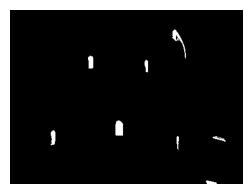

In [8]:
plotImageF(resultImage, figureSize = 3)    